In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
db_filename = "rasmus_classification_muon_3neutrino_3mio.db"
db_filepath = "C:/Users/jv97/Desktop/github/Neutrino-Machine-Learning/raw_data/{}".format(db_filename)

In [3]:
tfs = pd.read_pickle("C:/Users/jv97/Desktop/github/Neutrino-Machine-Learning/datasets/transformers.pkl")

In [4]:
event_nos = pd.read_pickle("C:/Users/jv97/Desktop/github/Neutrino-Machine-Learning/datasets/event_nos_500k_muon_set1.pkl")


<IPython.core.display.Javascript object>


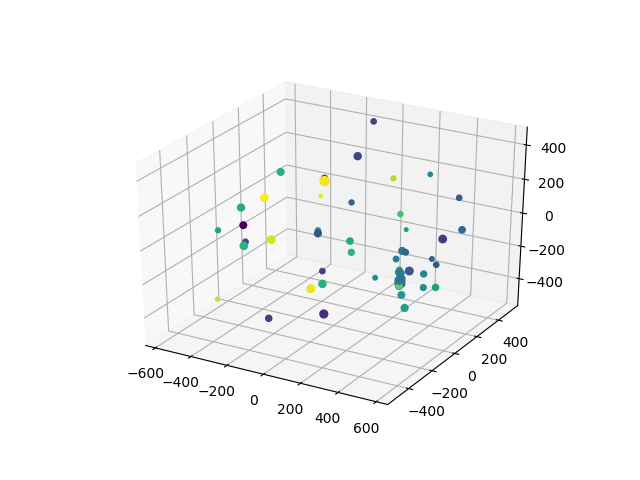

<IPython.core.display.Javascript object>


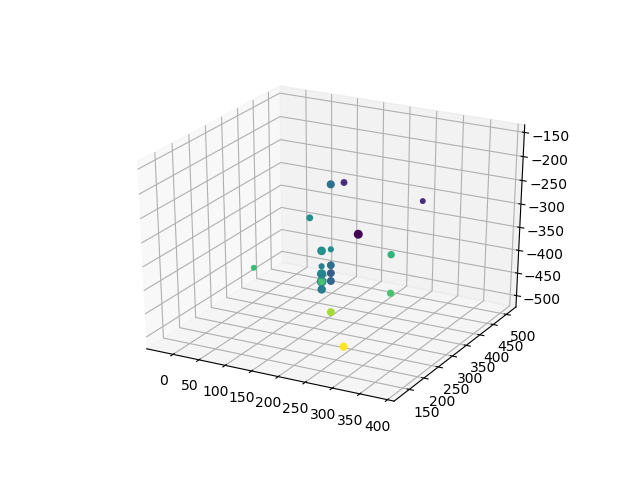

In [30]:
event_no = event_nos.sample(1).values.item()

query = "SELECT charge_log10, time, dom_x, dom_y, dom_z, pulse_width, SRTInIcePulses FROM features WHERE event_no == {}".format(event_no)
with sqlite3.connect(str(db_filepath)) as con:
    event = pd.read_sql(query,con)

for column in ['charge_log10', 'time', 'dom_x', 'dom_y', 'dom_z']:
    event[column] = tfs['features'][column].inverse_transform(event[column].to_numpy().reshape(-1,1))

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(event.dom_x,event.dom_y,event.dom_z,s=20*10**event.charge_log10,c=event.time,alpha=1)

mask = event.SRTInIcePulses == 1

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(event[mask].dom_x,event[mask].dom_y,event[mask].dom_z,s=20*10**event[mask].charge_log10,c=event[mask].time,alpha=1)

In [31]:
import torch

In [32]:
dat = torch.tensor(event[mask][['charge_log10','time','dom_x','dom_y','dom_z']].values)
middle = (10**dat[:,0].view(-1,1) * dat[:,[2,3,4]]).sum(axis=0)/(10**dat[:,0]).sum(axis=0)

<IPython.core.display.Javascript object>


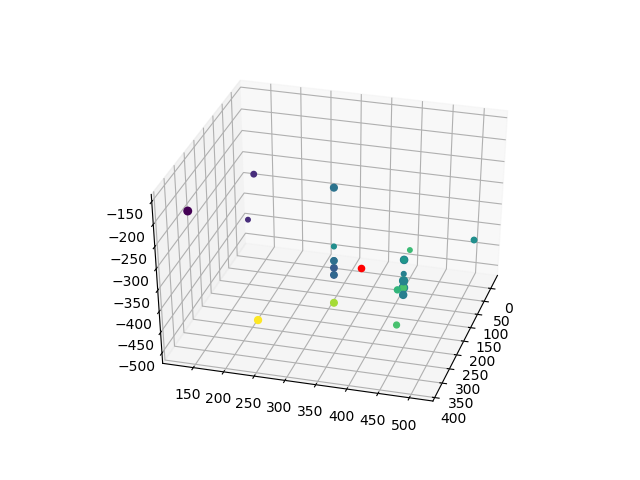

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(event[mask].dom_x,event[mask].dom_y,event[mask].dom_z,s=20*10**event[mask].charge_log10,c=event[mask].time,alpha=1)
ax.scatter(*middle,c='r')

In [49]:
# dat[:,-3:] /= 300
frm = [0,1]
to = [1,5]
pos = dat[:,-3:]
cart = pos[frm] - pos[to]
rho = torch.norm(cart, p=2, dim=-1).view(-1, 1)
rho_mask = rho.squeeze() != 0
cart[rho_mask] = cart[rho_mask] / rho[rho_mask]
T_diff = dat[to,1] - dat[frm,1]
dat[to,1], dat[frm,1]

(tensor([ 9886., 10316.], dtype=torch.float64),
 tensor([9886., 9886.], dtype=torch.float64))

In [71]:
torch.cat([cart.type_as(pos),rho,T_diff.view(-1,1)], dim=1)

tensor([[ 0.0000e+00,  0.0000e+00,  1.0000e+00,  5.6733e-02,  0.0000e+00],
        [ 6.0106e-01, -7.9603e-01, -7.1132e-02,  4.0723e-01,  4.3000e+02]],
       dtype=torch.float64)

Down here i play with an edge_creator based on sorting in time:

In [114]:
tmp = event[mask].copy()
tmp1 = torch.tensor(tmp.iloc[:tmp.shape[0]//2].values)
tmp2 = torch.tensor(tmp.iloc[tmp.shape[0]//2:].values)
I = torch.zeros(tmp.shape[0])
I[tmp.shape[0]//2:] = 1

tmp = torch.cat([tmp1,tmp2],dim=0)

In [251]:
tmp1[:,1], tmp2[:,1]

(tensor([10131.,  9880.,  9890.,  9896.,  9901.,  9910.,  9934.,  9952.,  9923.,
          9928.,  9933.,  9945.,  9959.], dtype=torch.float64),
 tensor([ 9969., 10191., 10433., 10007., 10033., 10295., 11060.,  9967.,  9943.,
         10256., 10057.,  9913., 10100., 10200.], dtype=torch.float64))

In [255]:
e_ind = torch.cat([batch_sort[:-1].view(1,-1),batch_sort[1:].view(1,-1)],dim=0)

In [260]:
a = torch.ones(e_ind.shape[1],dtype=bool)
a[(torch.cumsum(counts,0) - 1)[:-1]] = False
e_ind = e_ind[:,a]

In [282]:
torch.cat([e_ind,e_ind.flip(0)],dim=1)

tensor([[ 1,  2,  3,  4,  5,  8,  9, 10,  6, 11,  7, 12, 24, 21, 20, 13, 16, 17,
         23, 25, 14, 26, 22, 18, 15,  2,  3,  4,  5,  8,  9, 10,  6, 11,  7, 12,
          0, 21, 20, 13, 16, 17, 23, 25, 14, 26, 22, 18, 15, 19],
        [ 2,  3,  4,  5,  8,  9, 10,  6, 11,  7, 12,  0, 21, 20, 13, 16, 17, 23,
         25, 14, 26, 22, 18, 15, 19,  1,  2,  3,  4,  5,  8,  9, 10,  6, 11,  7,
         12, 24, 21, 20, 13, 16, 17, 23, 25, 14, 26, 22, 18, 15]])

In [223]:
torch.cat([torch.arange(tmp.shape[0]).view(-1,1),tmp[:,1].view(-1,1)],dim=1)

tensor([[0.0000e+00, 1.0131e+04],
        [1.0000e+00, 9.8800e+03],
        [2.0000e+00, 9.8900e+03],
        [3.0000e+00, 9.8960e+03],
        [4.0000e+00, 9.9010e+03],
        [5.0000e+00, 9.9100e+03],
        [6.0000e+00, 9.9340e+03],
        [7.0000e+00, 9.9520e+03],
        [8.0000e+00, 9.9230e+03],
        [9.0000e+00, 9.9280e+03],
        [1.0000e+01, 9.9330e+03],
        [1.1000e+01, 9.9450e+03],
        [1.2000e+01, 9.9590e+03],
        [1.3000e+01, 9.9690e+03],
        [1.4000e+01, 1.0191e+04],
        [1.5000e+01, 1.0433e+04],
        [1.6000e+01, 1.0007e+04],
        [1.7000e+01, 1.0033e+04],
        [1.8000e+01, 1.0295e+04],
        [1.9000e+01, 1.1060e+04],
        [2.0000e+01, 9.9670e+03],
        [2.1000e+01, 9.9430e+03],
        [2.2000e+01, 1.0256e+04],
        [2.3000e+01, 1.0057e+04],
        [2.4000e+01, 9.9130e+03],
        [2.5000e+01, 1.0100e+04],
        [2.6000e+01, 1.0200e+04]], dtype=torch.float64)

In [225]:
ind = torch.argsort(tmp[:,1])
# torch.cat([tmp[ind,1][I[ind] == 0],tmp[ind,1][I[ind] == 1]],dim=0)

In [227]:
tmp[:,1]

tensor([10131.,  9880.,  9890.,  9896.,  9901.,  9910.,  9934.,  9952.,  9923.,
         9928.,  9933.,  9945.,  9959.,  9969., 10191., 10433., 10007., 10033.,
        10295., 11060.,  9967.,  9943., 10256., 10057.,  9913., 10100., 10200.],
       dtype=torch.float64)

In [226]:
batch_sort = ind[torch.argsort(I[ind])]
batch_time_sorted = tmp[batch_sort,1]
batch_time_sorted

tensor([ 9880.,  9890.,  9896.,  9901.,  9910.,  9923.,  9928.,  9933.,  9934.,
         9945.,  9952.,  9959., 10131.,  9913.,  9943.,  9967.,  9969., 10007.,
        10033., 10057., 10100., 10191., 10200., 10256., 10295., 10433., 11060.],
       dtype=torch.float64)

In [193]:
reverse_batch_sort = torch.argsort(torch.argsort(I[ind]))[torch.argsort(ind)]

In [224]:
all(batch_time_sorted[reverse_batch_sort] == tmp[:,1])

True

In [185]:
# batch_time_sorted
unique_I, counts = I.unique(return_counts=True)
e_ind = torch.cat([torch.arange(I.shape[0]-1).view(1,-1),torch.arange(1,I.shape[0]).view(1,-1)],0)

a = torch.ones(e_ind.shape[1],dtype=bool)
a[torch.cumsum(counts,0)[:-1]] = False

e_ind = e_ind[:,a]


In [230]:
reverse_batch_sort

tensor([12,  0,  1,  2,  3,  4,  8, 10,  5,  6,  7,  9, 11, 16, 21, 25, 17, 18,
        24, 26, 15, 14, 23, 19, 13, 20, 22])

In [240]:
torch.cat([batch_sort[:-1].view(1,-1),batch_sort[1:].view(1,-1)],dim=0)

tensor([[ 1,  2,  3,  4,  5,  8,  9, 10,  6, 11,  7, 12,  0, 24, 21, 20, 13, 16,
         17, 23, 25, 14, 26, 22, 18, 15],
        [ 2,  3,  4,  5,  8,  9, 10,  6, 11,  7, 12,  0, 24, 21, 20, 13, 16, 17,
         23, 25, 14, 26, 22, 18, 15, 19]])

In [236]:
torch.arange(I.shape[0])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26])

In [188]:
e_ind[:,torch.argsort(torch.argsort(I[ind]))[torch.argsort(ind)]]

IndexError: index 25 is out of bounds for dimension 0 with size 25

In [195]:
torch.arange(I.shape[0])[reverse_batch_sort]

tensor([12,  0,  1,  2,  3,  4,  8, 10,  5,  6,  7,  9, 11, 16, 21, 25, 17, 18,
        24, 26, 15, 14, 23, 19, 13, 20, 22])

In [196]:
torch.arange(1,I.shape[0]+1)[reverse_batch_sort]

tensor([13,  1,  2,  3,  4,  5,  9, 11,  6,  7,  8, 10, 12, 17, 22, 26, 18, 19,
        25, 27, 16, 15, 24, 20, 14, 21, 23])

In [203]:
batch_sort

tensor([ 1,  2,  3,  4,  5,  8,  9, 10,  6, 11,  7, 12,  0, 24, 21, 20, 13, 16,
        17, 23, 25, 14, 26, 22, 18, 15, 19])

In [199]:
tmp[:,1]

tensor([10131.,  9880.,  9890.,  9896.,  9901.,  9910.,  9934.,  9952.,  9923.,
         9928.,  9933.,  9945.,  9959.,  9969., 10191., 10433., 10007., 10033.,
        10295., 11060.,  9967.,  9943., 10256., 10057.,  9913., 10100., 10200.],
       dtype=torch.float64)